# Using the Trained Model to do Classification

## Loading the BDT Model

In [1]:
# Import all the things needed for the BDT training
import random
import pandas
import pandas.core.common as com
from pandas.core.index import Index

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import  train_test_split

# Load the BDT model
bdt = joblib.load('../BDT_model_g2_20_Gap400/BDTmodel.pkl')

/home/zmind/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Generating S1s and S2s seperately

### Generating S1s

In [2]:
# Just import something needed
import numpy as np
import strax
import straxen
import wfsim

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from multihist import Histdd, Hist1d
from scipy import stats
import matplotlib.pyplot as plt

/home/zmind/anaconda3/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):


In [3]:
# Strax Settings
n_photon_min = 50
n_photon_max = 250
n_electron_min = 1
n_electron_max = 5

st = strax.Context(
    register=wfsim.RawRecordsFromFax,
#     config=dict((detector="XENONnT"))
    **straxen.contexts.common_opts)

st.set_config(dict(fax_file=None))
st.set_config(dict(peak_gap_threshold=400))

strax.Mailbox.DEFAULT_TIMEOUT=100000

In [4]:
# Generating S1s
st.set_config(dict(nchunk=1, event_rate = 1, chunk_size = 2000))

run_id = '170603_0604'

dtype = wfsim.strax_interface.instruction_dtype

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(1 * n, dtype=dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['t'] = np.repeat(uniform_times, 1) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s1'], n)
    instructions['recoil'] = ['er' for i in range(n * 1)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 1)
    instructions['y'] = np.repeat(r * np.sin(t), 1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 1)

    nphotons = np.random.uniform(n_photon_min, n_photon_max, n)
    nelectrons = np.random.uniform(n_electron_min, n_electron_max, n)
    instructions['amp'] = np.vstack([nphotons]).T.flatten().astype(int)

    return instructions

wfsim.strax_interface.rand_instructions = rand_instructions
wfsim.strax_interface.instruction_dtype = dtype

In [5]:
records_s1 = st.get_array(run_id,'records')
peaks_s1 = st.get_array(run_id, ['peaks','peak_classification'])
truth_s1 = st.get_df(run_id, 'truth')

In [6]:
print('Number of signals classified as S1: ', len(peaks_s1[peaks_s1['type']==1]['type']))
print('Number of signals classified as S2: ', len(peaks_s1[peaks_s1['type']==2]['type']))
print('Number of signals classified as neither S1 nor S2: ', len(peaks_s1[peaks_s1['type']==0]['type']))
print('All signals: ',len(peaks_s1['type']))

Number of signals classified as S1:  1988
Number of signals classified as S2:  4
Number of signals classified as neither S1 nor S2:  15
All signals:  2007


In [7]:
peaks_true_s1 = peaks_s1[5e+8-peaks_s1['time']%(5e+8)<600]
peaks_classified_true_s1 = peaks_s1[(5e+8-peaks_s1['time']%(5e+8)<600) & (peaks_s1['type']==1)]
print('Number of true S1 signals: ', len(peaks_true_s1))
print('Number of correctly classified S1: ', len(peaks_classified_true_s1))

Number of true S1 signals:  1999
Number of correctly classified S1:  1988


### Generating S2s

In [8]:
# Generating S2s
st.set_config(dict(nchunk=1, event_rate = 1, chunk_size = 2000))

run_id = '170604_0605'

dtype = wfsim.strax_interface.instruction_dtype

def rand_instructions(c):
    n = c['nevents'] = c['event_rate'] * c['chunk_size'] * c['nchunk']
    c['total_time'] = c['chunk_size'] * c['nchunk']

    instructions = np.zeros(1 * n, dtype=dtype)
    uniform_times = c['total_time'] * (np.arange(n) + 0.5) / n
    instructions['t'] = np.repeat(uniform_times, 1) * int(1e9)
    instructions['event_number'] = np.digitize(instructions['t'], 
         1e9 * np.arange(c['nchunk']) * c['chunk_size']) - 1
    instructions['type'] = np.tile(['s2'], n)
    instructions['recoil'] = ['er' for i in range(n * 1)]

    r = np.sqrt(np.random.uniform(0, 2500, n))
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 1)
    instructions['y'] = np.repeat(r * np.sin(t), 1)
    instructions['z'] = np.repeat(np.random.uniform(-100, 0, n), 1)

    nphotons = np.random.uniform(n_photon_min, n_photon_max, n)
    nelectrons = np.random.uniform(n_electron_min, n_electron_max, n)
    instructions['amp'] = np.vstack([nelectrons]).T.flatten().astype(int)

    return instructions

wfsim.strax_interface.rand_instructions = rand_instructions
wfsim.strax_interface.instruction_dtype = dtype

In [9]:
records_s2 = st.get_array(run_id,'records')
peaks_s2 = st.get_array(run_id, ['peaks','peak_classification'])
truth_s2 = st.get_df(run_id, 'truth')

In [10]:
print('Number of signals classified as S1: ', len(peaks_s2[peaks_s2['type']==1]['type']))
print('Number of signals classified as S2: ', len(peaks_s2[peaks_s2['type']==2]['type']))
print('All signals: ',len(peaks_s2['type']))

Number of signals classified as S1:  369
Number of signals classified as S2:  1130
All signals:  1955


In [11]:
# Calculate the Peak_classification Correct Rate
dtype_temp = peaks_s2.dtype
peaks_true_s2 = np.zeros(0, dtype=dtype_temp)
peaks_afterpulse = np.zeros(0, dtype=dtype_temp)
truth_s2_time = truth_s2[['t_first_photon']].values
for ipeak in peaks_s2:
    for time in truth_s2_time:
        peaks_temp = np.zeros(0, dtype=dtype_temp)
        if ((time[0]-ipeak['time'] > 0) & (time[0]-ipeak['time'] < 1000)):
            peaks_true_s2 = np.append(peaks_true_s2, ipeak)    
        elif ((time[0]-ipeak['time'] > -750000) & (time[0]-ipeak['time'] < 0)):
            peaks_afterpulse = np.append(peaks_afterpulse, ipeak)
            
peaks_classified_s1 = peaks_s2[peaks_s2['type']==1].copy()
peaks_classified_s2 = peaks_s2[peaks_s2['type']==2].copy() 

peaks_classified_true_s2 = np.zeros(0, dtype=dtype_temp)
truth_s2_time = truth_s2[['t_first_photon']].values
for ipeak in peaks_classified_s2:
    for time in truth_s2_time:
        if ((time[0]-ipeak['time'] > 0) & (time[0]-ipeak['time'] < 600)):
            peaks_classified_true_s2 = np.append(peaks_classified_true_s2, ipeak)

print('Number of true s2 signals (can be found based on truth time info): ', len(peaks_true_s2))
print('Number of after pulses: ', len(peaks_afterpulse))
print('Number of signals judged as S1: ', len(peaks_classified_s1))
print('Number of signals judged as S2: ', len(peaks_classified_s2))
print('Among them, number of true S2: ', len(peaks_classified_true_s2))

Number of true s2 signals (can be found based on truth time info):  1545
Number of after pulses:  410
Number of signals judged as S1:  369
Number of signals judged as S2:  1130
Among them, number of true S2:  922


In [12]:
len(truth_s2[(np.isnan(truth_s2.t_first_photon))])

455

### S1 and S2 comparison

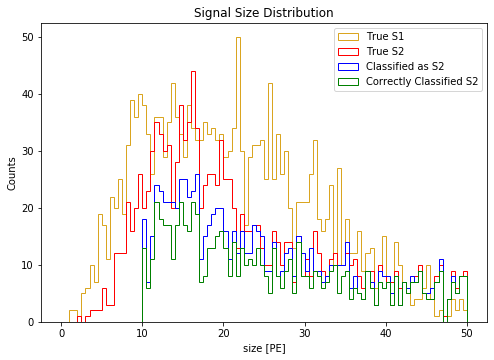

In [13]:
# Compare the Area Distribution
fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(peaks_true_s1['area'],bins=100,range=(0,50),color='goldenrod',histtype='step',label='True S1')
plt.hist(peaks_true_s2['area'],bins=100,range=(0,50),color='r',histtype='step',label='True S2')
plt.hist(peaks_classified_s2['area'],bins=100,range=(0,50),color='b',histtype='step',label='Classified as S2')
plt.hist(peaks_classified_true_s2['area'],bins=100,range=(0,50),color='g',histtype='step',label='Correctly Classified S2')
plt.legend(loc='best')
plt.xlabel('size [PE]')
plt.ylabel('Counts')
plt.title('Signal Size Distribution')
plt.show()

### Classification

In [14]:
# Prepare the arraies for classification
peaks_true_s1_features_list = []
peaks_true_s2_features_list = []
peaks_afterpulse_features_list = []

peaks_true_s1_area_list = []
peaks_true_s2_area_list = []
peaks_afterpulse_area_list = []

for i in range(0, len(peaks_true_s1)):
    peaks_true_s1_features_list.append([peaks_true_s1['width'][i,5], peaks_true_s1['width'][i,9],
                                        peaks_true_s1['width'][i,5]/peaks_true_s1['width'][i,9], 
                                        -peaks_true_s1['area_decile_from_midpoint'][i,1], peaks_true_s1['area_decile_from_midpoint'][i,9],
                                        -peaks_true_s1['area_decile_from_midpoint'][i,1]/peaks_true_s1['area_decile_from_midpoint'][i,9]])
    peaks_true_s1_area_list.append([peaks_true_s1['area'][i]])

for i in range(0, len(peaks_true_s2)):
    peaks_true_s2_features_list.append([peaks_true_s2['width'][i,5], peaks_true_s2['width'][i,9],
                                        peaks_true_s2['width'][i,5]/peaks_true_s2['width'][i,9],
                                        -peaks_true_s2['area_decile_from_midpoint'][i,1], peaks_true_s2['area_decile_from_midpoint'][i,9],
                                        -peaks_true_s2['area_decile_from_midpoint'][i,1]/peaks_true_s2['area_decile_from_midpoint'][i,9]])
    peaks_true_s2_area_list.append([peaks_true_s2['area'][i]])

for i in range(0, len(peaks_afterpulse)):
    peaks_afterpulse_features_list.append([peaks_afterpulse['width'][i,5], peaks_afterpulse['width'][i,9], 
                                           peaks_afterpulse['width'][i,5]/peaks_afterpulse['width'][i,9],
                                           -peaks_afterpulse['area_decile_from_midpoint'][i,1], peaks_afterpulse['area_decile_from_midpoint'][i,9], 
                                           -peaks_afterpulse['area_decile_from_midpoint'][i,1]/peaks_afterpulse['area_decile_from_midpoint'][i,9]])
    peaks_afterpulse_area_list.append([peaks_afterpulse['area'][i]])
    
peaks_true_s1_features = np.asarray(peaks_true_s1_features_list)
peaks_true_s2_features = np.asarray(peaks_true_s2_features_list)
peaks_afterpulse_features = np.asarray(peaks_afterpulse_features_list)

dtype_area = [('area', float)]
peaks_true_s1_area = np.asarray(peaks_true_s1_area_list, dtype_area)
peaks_true_s2_area = np.asarray(peaks_true_s2_area_list, dtype_area)

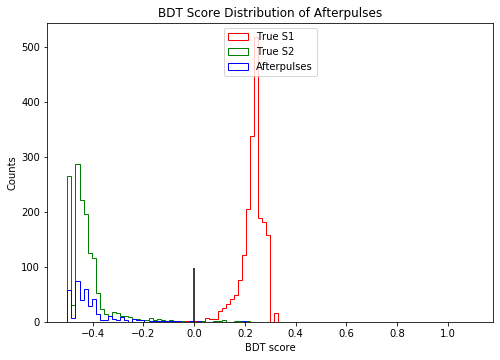

In [15]:
# Draw the BDT score distribution
BDTscore_true_s1 = bdt.decision_function(peaks_true_s1_features)
BDTscore_true_s2 = bdt.decision_function(peaks_true_s2_features)
BDTscore_afterpulse = bdt.decision_function(peaks_afterpulse_features)

BDT_lower_lim = 0.0

fig=plt.figure(figsize=(8,5.5))
fig.patch.set_color('white')
plt.hist(BDTscore_true_s1,bins=100,range=(-0.5,1.1),color='r',histtype='step',label='True S1')
plt.hist(BDTscore_true_s2,bins=100,range=(-0.5,1.1),color='g',histtype='step',label='True S2')
plt.hist(BDTscore_afterpulse,bins=100,range=(-0.5,1.1),color='b',histtype='step',label='Afterpulses')
plt.legend(loc='upper center')
plt.xlabel('BDT score')
plt.ylabel('Counts')
plt.title('BDT Score Distribution of Afterpulses')
plt.vlines(BDT_lower_lim, 0, 98)
plt.show()

In [16]:
#BDTscore_true_s1[BDTscore_true_s1>BDT_lower_lim]

In [17]:
# Print the Correct Judgement Rate
print ('Among All True S1 Signals (', len(peaks_true_s1), 'Found ):          Peak Classification           BDT Classification  ')
print ('Correctly Judged as S1                               ', 
       round(len(peaks_true_s1[peaks_true_s1['type']==1])/len(peaks_true_s1), 4),
       '                        ',
       round(len(BDTscore_true_s1[BDTscore_true_s1>BDT_lower_lim])/len(peaks_true_s1), 4))
print ('Incorrectly Judged as S2                             ', 
       round(len(peaks_true_s1[peaks_true_s1['type']==2])/len(peaks_true_s1), 4),
       '                           ',
       round(len(BDTscore_true_s1[BDTscore_true_s1<BDT_lower_lim])/len(peaks_true_s1), 4))

print ('')

print ('Among All True S2 Signals (', len(peaks_true_s2), 'Found ):           Peak Classification           BDT Classification  ')
print ('Correctly Judged as S2                               ', 
       round(len(peaks_true_s2[peaks_true_s2['type']==2])/len(peaks_true_s2), 4),
       '                        ',
       round(len(BDTscore_true_s2[BDTscore_true_s2<BDT_lower_lim])/len(peaks_true_s2), 4))
print ('Incorrectly Judged as S1                             ', 
       round(len(peaks_true_s2[peaks_true_s2['type']==1])/len(peaks_true_s2), 4),
       '                        ',
       round(len(BDTscore_true_s2[BDTscore_true_s2>BDT_lower_lim])/len(peaks_true_s2), 4))

Among All True S1 Signals ( 1999 Found ):          Peak Classification           BDT Classification  
Correctly Judged as S1                                0.9945                          0.9975
Incorrectly Judged as S2                              0.0                             0.0025

Among All True S2 Signals ( 1545 Found ):           Peak Classification           BDT Classification  
Correctly Judged as S2                                0.5968                          0.9935
Incorrectly Judged as S1                              0.1806                          0.0065


In [18]:
# Drawing the Correct Judgement Rate
peaks_true_s1_area_BDT_list = []
peaks_true_s2_area_BDT_list = []

for i in range(0, len(BDTscore_true_s1)):
    if BDTscore_true_s1[i] > BDT_lower_lim:
        peaks_true_s1_area_BDT_list.append(peaks_true_s1_area[i])

for i in range(0, len(BDTscore_true_s2)):
    if BDTscore_true_s2[i] < BDT_lower_lim:
        peaks_true_s2_area_BDT_list.append(peaks_true_s2_area[i])

peaks_true_s1_area_BDT = np.asarray(peaks_true_s1_area_BDT_list, dtype_area)
peaks_true_s2_area_BDT = np.asarray(peaks_true_s2_area_BDT_list, dtype_area)

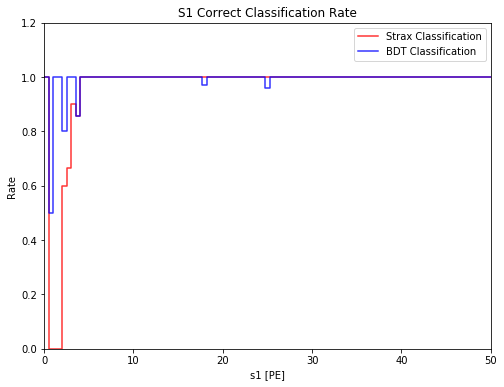

In [19]:
list_bin = np.linspace(0,50,100)
list_rate_raw = []
list_rate_bdt = []

for i in range(0,100):
    value_raw = len(peaks_classified_true_s1[(peaks_classified_true_s1['area'] > 0.5*i) & (peaks_classified_true_s1['area'] < 0.5*(i+1))])
    value_bdt = len(peaks_true_s1_area_BDT[(peaks_true_s1_area_BDT['area'] > 0.5*i) & (peaks_true_s1_area_BDT['area'] < 0.5*(i+1))])
    base = len(peaks_true_s1_area[(peaks_true_s1_area['area'] > 0.5*i) & (peaks_true_s1_area['area'] < 0.5*(i+1))])
    if (base!=0):
        rate_raw = value_raw/base
        rate_bdt = value_bdt/base
    elif (base==0):
        if (value_raw==0):
            rate_raw = 1
        else: 
            rate_raw = 100
            
        if (value_bdt==0):
            rate_bdt = 1
        else:
            rate_bdt = 100

    list_rate_raw.append(rate_raw)
    list_rate_bdt.append(rate_bdt)

fig = plt.figure(figsize=(8,6))
fig.patch.set_color('white')
plt.step(list_bin, list_rate_raw, color='r', alpha=0.8, label='Strax Classification')
plt.step(list_bin, list_rate_bdt, color='b', alpha=0.8, label='BDT Classification' )
plt.title('S1 Correct Classification Rate')
plt.xlim(0,50)
plt.ylim(0,1.2)
plt.legend(loc='best')
plt.xlabel('s1 [PE]')
plt.ylabel('Rate')
plt.show()

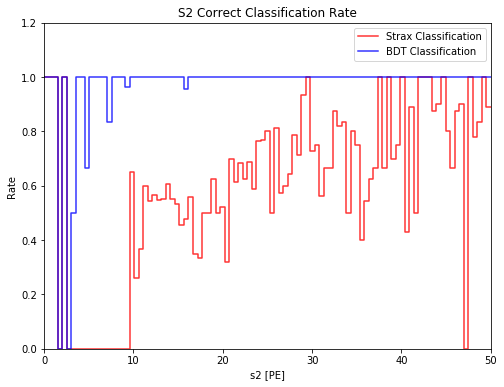

In [20]:
list_bin = np.linspace(0,50,100)
list_rate_raw = []
list_rate_bdt = []

for i in range(0,100):
    value_raw = len(peaks_classified_true_s2[(peaks_classified_true_s2['area'] > 0.5*i) & (peaks_classified_true_s2['area'] < 0.5*(i+1))])
    value_bdt = len(peaks_true_s2_area_BDT[(peaks_true_s2_area_BDT['area'] > 0.5*i) & (peaks_true_s2_area_BDT['area'] < 0.5*(i+1))])
    base = len(peaks_true_s2_area[(peaks_true_s2_area['area'] > 0.5*i) & (peaks_true_s2_area['area'] < 0.5*(i+1))])
    if (base!=0):
        rate_raw = value_raw/base
        rate_bdt = value_bdt/base
    elif (base==0):
        if (value_raw==0):
            rate_raw = 1
        else: 
            rate_raw = 100
            
        if (value_bdt==0):
            rate_bdt = 1
        else:
            rate_bdt = 100

    list_rate_raw.append(rate_raw)
    list_rate_bdt.append(rate_bdt)

fig = plt.figure(figsize=(8,6))
fig.patch.set_color('white')
plt.step(list_bin, list_rate_raw, color='r', alpha=0.8, label='Strax Classification')
plt.step(list_bin, list_rate_bdt, color='b', alpha=0.8, label='BDT Classification' )
plt.title('S2 Correct Classification Rate')
plt.xlim(0,50)
plt.ylim(0,1.2)
plt.legend(loc='best')
plt.xlabel('s2 [PE]')
plt.ylabel('Rate')
plt.show()

In [21]:
# Simple Cut
print ('S1 correct classification rate (simple cut): ', len(peaks_true_s1[-peaks_true_s1['area_decile_from_midpoint'][:,1]<60]) / len(peaks_true_s1))
print ('S2 correct classification rate (simple cut): ', len(peaks_true_s2[-peaks_true_s2['area_decile_from_midpoint'][:,1]>60]) / len(peaks_true_s2))

S1 correct classification rate (simple cut):  0.9959979989994997
S2 correct classification rate (simple cut):  0.96957928802589
